In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# Step 1. 인물모드 직접 해 보기

In [2]:
# 사람 사진
img_path_person = os.getenv('HOME')+'/aiffel/human_segmentation/images/person.png' 
# 고양이 사진
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/animals.png'  
# 배경 사진
img_path_back = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  

img_orig_person = cv2.imread(img_path_person) 
img_orig_cat = cv2.imread(img_path_cat) 
img_orig_back = cv2.imread(img_path_back) 

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc1dceeff10>)

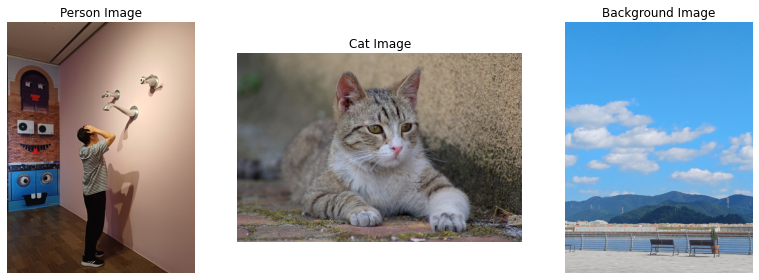

In [4]:
import cv2
import matplotlib.pyplot as plt

# 이미지를 옆으로 배열하기 위한 subplot 설정
plt.figure(figsize=(12, 4))

# 사람 이미지
plt.subplot(131)
plt.imshow(cv2.cvtColor(img_orig_person, cv2.COLOR_BGR2RGB))
plt.title("Person Image")
plt.axis('off')

# 고양이 이미지
plt.subplot(132)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
plt.title("Cat Image")
plt.axis('off')

# 배경 이미지
plt.subplot(133)
plt.imshow(cv2.cvtColor(img_orig_back, cv2.COLOR_BGR2RGB))
plt.title("Background Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [6]:
# segmentAsPascalvoc()함수를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용
segvalues_person, output_person = model.segmentAsPascalvoc(img_path_person)

In [7]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [8]:
def get_colormap(label_name):
    # 아래 코드를 이해하지 않아도 좋습니다
    # PixelLib에서 그대로 가져온 코드입니다
    # 주목해야 할 것은 생상 코드 결과물이예요!
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    # colormap[:20]

    index = LABEL_NAMES.index(label_name)  # 데이터 라벨 인덱스
    seg_color = colormap[index].tolist()  # BGR
    seg_color = seg_color[::-1]  # BGR2RGB
    return seg_color  # RGB

# 인물 아웃포커싱

(1400, 1050)


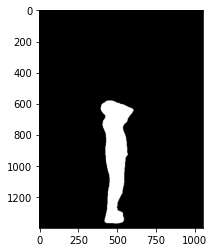

In [9]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_color = get_colormap('person')
seg_map = np.all(output_person==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

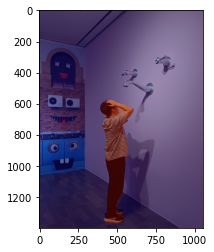

In [10]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig_person.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

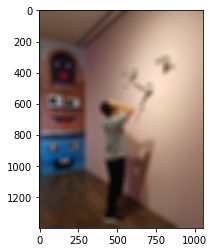

In [11]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig_person, (40,40))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

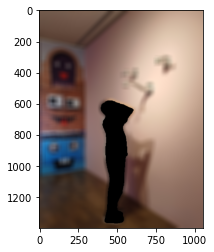

In [12]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
person_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(person_img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

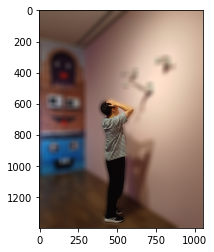

In [13]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
person_img_concat = np.where(person_img_mask_color==255, img_orig_person, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(person_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이 아웃포커싱

background
cat

seg_color로만 이루어진 마스크 생성


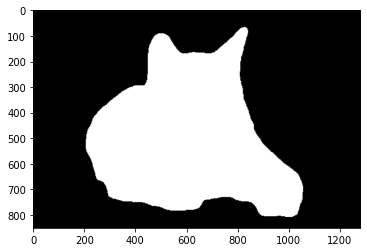

이미지 블러링


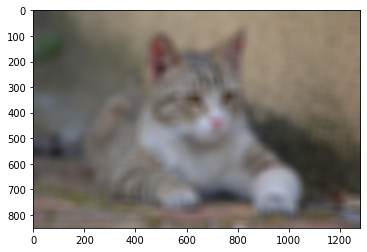

세그멘테이션 마스크를 이용하여 배경만 추출


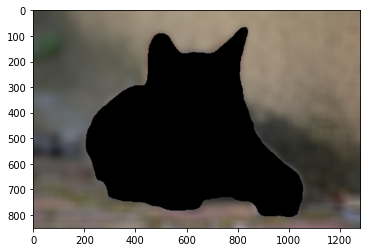

결과


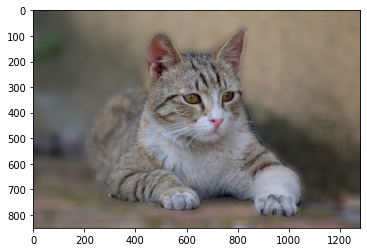

In [14]:
segvalues_cat, output_cat = model.segmentAsPascalvoc(img_path_cat)

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues_cat['class_ids']:
    print(LABEL_NAMES[class_id])

seg_color = get_colormap('cat')
cat_seg_map = np.all(output_cat==seg_color, axis=-1)
plt.imshow(cat_seg_map, cmap='gray')
print("")
print("seg_color로만 이루어진 마스크 생성")
plt.show()

cat_img_mask = cat_seg_map.astype(np.uint8) * 255

cat_img_orig_blur = cv2.blur(img_orig_cat, (40,40))

plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
print("이미지 블러링")
plt.show()


cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
print("세그멘테이션 마스크를 이용하여 배경만 추출")
plt.show()

cat_img_concat = np.where(cat_img_mask_color==255, img_orig_cat, cat_img_bg_blur)

plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
print("결과")
plt.show()

# 배경사진에 인물 사진 크로마키 배경 합성

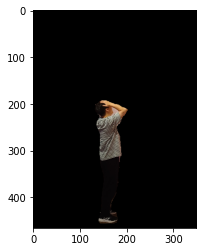

In [15]:
# 사람만 남기고 나머지는 0(검은색) 처리
person_only_img_concat = np.where(person_img_mask_color==255, img_orig_person, 0)

# 사람 resize
h, w, c = person_only_img_concat.shape
person_img_resize = cv2.resize(person_only_img_concat, (w//3, h//3), cv2.INTER_AREA)

plt.imshow(cv2.cvtColor(person_img_resize, cv2.COLOR_BGR2RGB))

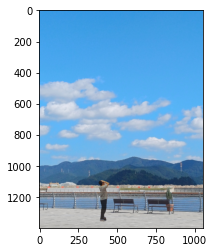

In [16]:
back_img_show = img_orig_back.copy()

refined_y = 900
refined_x = 250

alpha = 0.2  # 투명도
sticker_area = back_img_show[refined_y:refined_y+person_img_resize.shape[0], refined_x:refined_x+person_img_resize.shape[1]]
back_img_show[refined_y:refined_y +person_img_resize.shape[0], refined_x:refined_x+person_img_resize.shape[1]] = \
cv2.addWeighted(sticker_area, alpha, np.where(person_img_resize==0,sticker_area,person_img_resize).astype(np.uint8), 1-alpha, 0)

plt.imshow(cv2.cvtColor(back_img_show, cv2.COLOR_BGR2RGB))

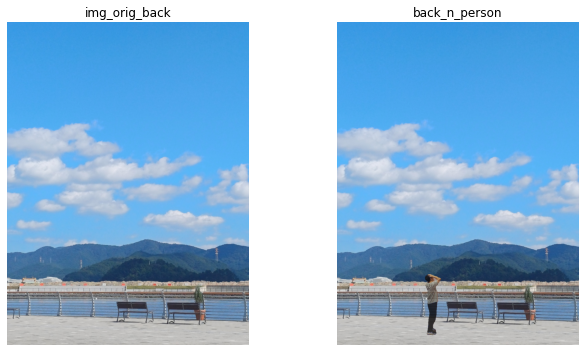

In [17]:
# 첫 번째 이미지와 두 번째 이미지
image1 = cv2.cvtColor(img_orig_back, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(back_img_show, cv2.COLOR_BGR2RGB)

# 이미지와 제목을 함께 표시하는 함수 정의
def show_image_with_title(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# 이미지를 나란히 표시하기 위한 subplot 설정
plt.figure(figsize=(10, 5))

# 첫 번째 이미지
plt.subplot(121)  # 1행 2열 중 첫 번째 위치
show_image_with_title(image1, 'img_orig_back')

# 두 번째 이미지
plt.subplot(122)  # 1행 2열 중 두 번째 위치
show_image_with_title(image2, 'back_n_person')

plt.tight_layout()  # 이미지 간 간격 조정
plt.show()

# Step 2. 사진에서 문제점 찾기

- 사람 이미지의 경계선 부분이 거의 뭉개져서 깔끔하지 못하다.

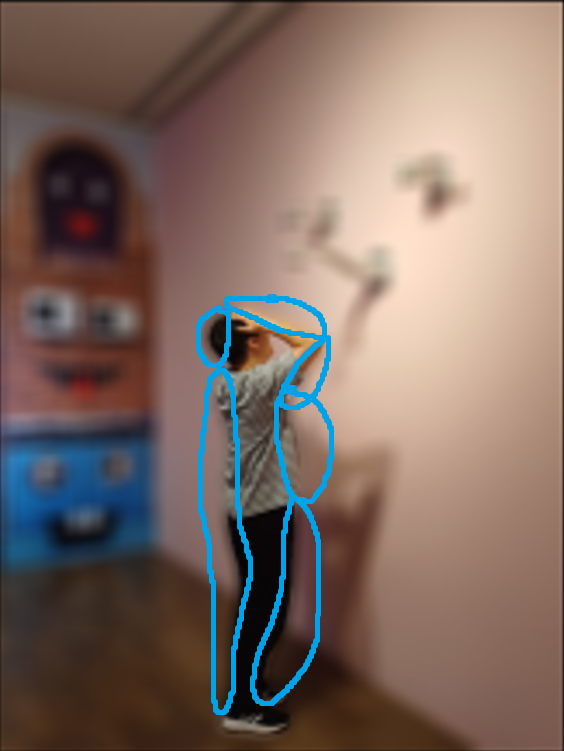

- 고양이 이미지는 잘 나오긴 했지만 뒷부분이 뭉개진 느낌이 든다.

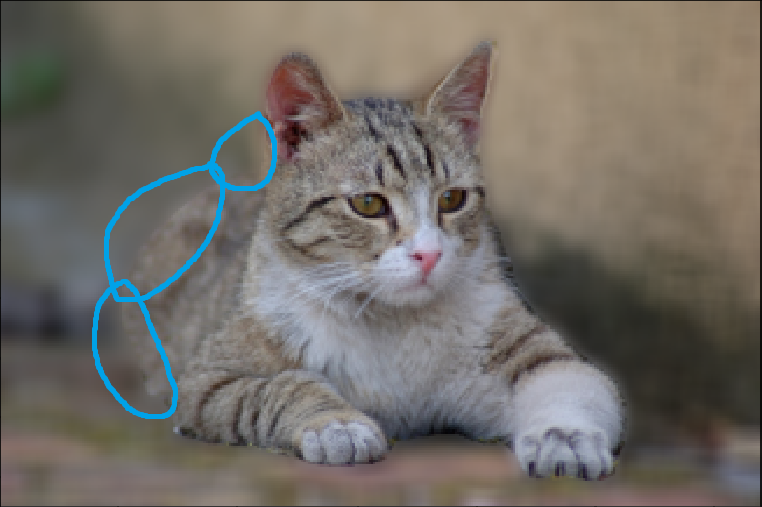

# Step 3. 해결 방법을 제안해 보기

1. 마스크 경계 주변에서 뭉개지는 현상을 보이는데, 이는 마스크 경계가 픽셀 수준에서 정확하게 정의되지 않기 때문에 발생한다.

=> 마스크 경계를 부드럽게 만들기 위해서 마스크에 에지 강화 필터 또는 모폴로지 연산을 적용할 수 있다. 이러한 연산은 경계를 더 선명하게 만들고 뭉개짐을 감소시킨다.

    - 에지 강화 필터는 경계선 주변의 픽셀을 강조한다. 이는 경계선을 더 선명하게 만든다.
    - 에지 검출의 위해 cv2.Canny() 함수 적용
    - 블러링 함수로 cv2.GaussianBlur() 함수 사용

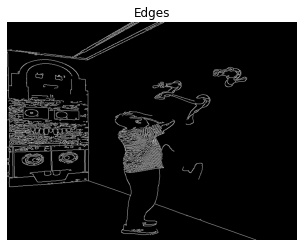

In [18]:
# 에지 검출

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt  # matplotlib를 사용하여 이미지를 표시합니다.

# 이미지 파일 경로
image_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/person.png' 

# 이미지 불러오기 (크기 조정)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지를 그레이스케일로 바로 읽어오고 크기를 조정합니다.
image = cv2.resize(image, (800, 600))  # 이미지 크기를 축소

# Canny 에지 검출을 수행하여 에지 감지
edges = cv2.Canny(image, threshold1=200, threshold2=100)

# 에지 강화 필터를 사용하여 에지를 강화
kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])
enhanced_edges = cv2.filter2D(edges, -1, kernel)

# 결과 이미지를 저장
cv2.imwrite('enhanced_edges.png', enhanced_edges)

# 결과 이미지를 matplotlib를 사용하여 표시
plt.imshow(enhanced_edges, cmap='gray')
plt.title('Edges')
plt.axis('off')  # 좌표축을 표시하지 않습니다.
plt.show()


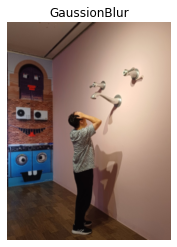

In [20]:
# 에지 검출과 GaussianBlur() 합쳐서 표현

import cv2
import numpy as np
from matplotlib import pyplot as plt

# 원본 이미지 파일 경로
original_image_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/person.png'

# 에지 강화된 이미지 불러오기
enhanced_edges = cv2.imread('enhanced_edges.jpg', cv2.IMREAD_GRAYSCALE)

# 원본 이미지 불러오기
original_image = cv2.imread(original_image_path)

# 경계선이 잘 이루어진 마스크 생성
boundary_mask = cv2.Canny(enhanced_edges, threshold1=30, threshold2=100)

# boundary_mask의 크기를 original_image와 맞춰줍니다.
boundary_mask = cv2.resize(boundary_mask, (original_image.shape[1], original_image.shape[0]))

# 경계선이 잘 이루어진 마스크를 사용하여 사람 부분만 블러 처리
person_blurred = cv2.GaussianBlur(original_image, (15, 15), 0)
blurred_original = original_image.copy()
blurred_original[boundary_mask != 0] = person_blurred[boundary_mask != 0]

# 결과 이미지를 matplotlib를 사용하여 표시
plt.imshow(cv2.cvtColor(blurred_original, cv2.COLOR_BGR2RGB))
plt.title('GaussionBlur')
plt.axis('off')
plt.show()


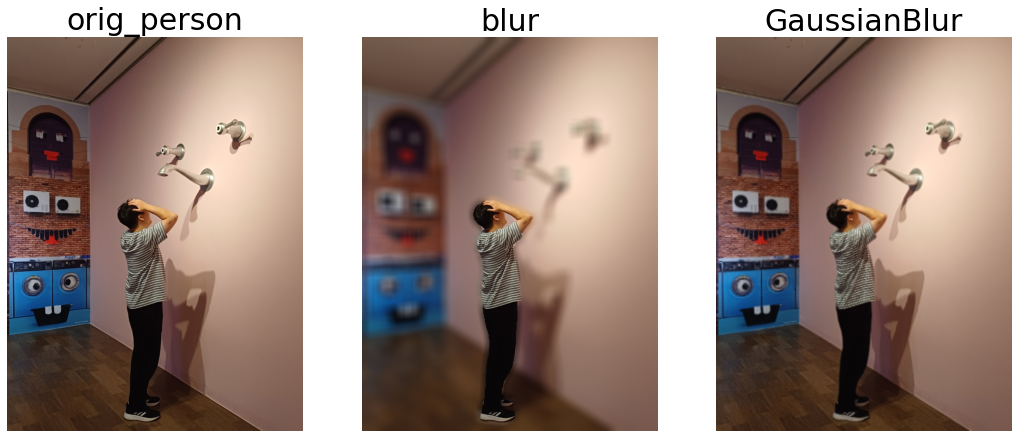

In [23]:
plt.figure(figsize=(18,12))

plt.subplot(131)
plt.imshow(cv2.cvtColor(img_orig_person, cv2.COLOR_BGR2RGB))
plt.title('orig_person')
plt.rc('axes', titlesize=30)
plt.axis('off')

plt.subplot(132)
plt.imshow(cv2.cvtColor(person_img_concat, cv2.COLOR_BGR2RGB))
plt.title('blur')
plt.rc('axes', titlesize=30)
plt.axis('off')

plt.subplot(133)
plt.imshow(cv2.cvtColor(blurred_original, cv2.COLOR_BGR2RGB))
plt.title('GaussianBlur')
plt.rc('axes', titlesize=30)
plt.axis('off')


plt.show()

In [22]:
# 모폴로지 연산을 사용하여 해볼려고 했으나 실패...

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 파일 경로
image_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/person.png'
image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)

# 커널 크기 정의
kernel_size = 5  # 열림 및 닫힘 연산에 사용할 커널 크기를 조절하세요

# 열림 연산 수행 (침식 다음 팽창)
kernel = np.ones((kernel_size, kernel_size), np.uint8)
opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# 닫힘 연산 수행 (팽창 다음 침식)
kernel = np.ones((kernel_size, kernel_size), np.uint8)
closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# 세그멘테이션 마스크 생성 (사람 부분 추출)
seg_color = get_colormap('person')
person_mask = np.all(opened_image == seg_color, axis=-1)

# 사람 부분에만 블러 처리 적용
person_blurred_opened_image = opened_image.copy()
person_blurred_opened_image[person_mask] = cv2.blur(person_blurred_opened_image[person_mask], (30, 30))

person_blurred_closed_image = closed_image.copy()
person_blurred_closed_image[person_mask] = cv2.blur(person_blurred_closed_image[person_mask], (30, 30))




segvalues_person_morphologyEx, output_person_morphologyEx = model.segmentAsPascalvoc(original_image_path)

seg_color = get_colormap('person')
person_2_seg_map = np.all(output_person_gaussian==seg_color, axis=-1)

person_2_img_mask = person_2_seg_map.astype(np.uint8) * 255

person_2_img_orig_blur = cv2.blur(img, (30,30))

person_2_img_mask_color = cv2.cvtColor(person_2_img_mask, cv2.COLOR_GRAY2BGR)
person_2_img_bg_mask = cv2.bitwise_not(person_2_img_mask_color)
person_2_img_bg_blur = cv2.bitwise_and(person_2_img_orig_blur, person_2_img_bg_mask)

person_2_img_concat = np.where(person_2_img_mask_color==255, img, person_2_img_bg_blur)

plt.imshow(cv2.cvtColor(person_2_img_concat, cv2.COLOR_BGR2RGB))
plt.show()



# 이미지 표시 (Matplotlib 사용)
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(cv2.cvtColor(opened_image, cv2.COLOR_BGR2RGB))
plt.title('Opened Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(cv2.cvtColor(person_blurred_opened_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Person in Opened Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(cv2.cvtColor(person_blurred_closed_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Person in Closed Image')
plt.axis('off')

plt.show()


error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/imgproc/src/box_filter.dispatch.cpp:446: error: (-215:Assertion failed) !_src.empty() in function 'boxFilter'


# 회고

- 작업을 하면서 사진 크기를 잘못 골랐는지 생각보다 blur 처리를 잘 못해서 방법을 찾아보면서 진행하였다.
- Gaussian blur를 사용하여 이미지의 노이즈를 감소시키거나 이미지를 부드럽게 만들기 위해서 사용하였지만, 잘못된건지 배경부분이 블러 처리가 제대로 안되는 느낌을 얻었다.
- blur 처리는 노이즈를 제거, 경계선 흐리게 만드는 방법이다.
- 좀 더 다양한 해결 방법을 모색해보고 해결해 보고싶다.